# Project Statistical Analysis

Karla y Mar

*Data Part Time Barcelona Dic 2019*

<img src="./img/5530085.jpeg" width="1000"> 

## Importamos librerías

In [13]:
import pandas as pd
import numpy as np
import re

#Stats
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#Visualización
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf
from datetime import datetime
from ipywidgets import interact
import ipywidgets as wdg
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import plotly.offline as off

#Request
import json
import requests
from pandas.io.json import json_normalize

import warnings

warnings.filterwarnings('ignore')
cf.go_offline()

## Importamos datos

### API con datos a nivel mundial

In [14]:
url='https://api.covid19api.com/all'
response = requests.get(url, headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"})
result=response.json()
df_coronavirus_raw = pd.DataFrame()
df_coronavirus_raw = json_normalize(result)
df_coronavirus_raw.head()

,Country,Province,Lat,Lon,Date,Cases,Status
0,,,0.0,0.0,0001-01-01T00:00:00Z,0,
1,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,1,confirmed
2,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,recovered
3,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,deaths
4,Afghanistan,,33.0,65.0,2020-02-24T00:00:00Z,1,confirmed


###  Países por continentes

In [15]:
df_continents = pd.read_csv('./data/concap.csv')
df_continents.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Somaliland,Hargeisa,9.550000,44.050000,NaN,Africa
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000,GS,Antarctica
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667,TF,Antarctica
3,Palestine,Jerusalem,31.766667,35.233333,PS,Asia
4,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe


### Unimos los datasets

In [16]:
# Clean some countries before merge
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Brunei', 'Country']='Brunei Darussalam'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Czechia', 'Country']='Czech Republic'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Hong Kong SAR', 'Country']='Hong Kong'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Iran (Islamic Republic of)', 'Country']='Iran'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Korea, South', 'Country']='South Korea'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='North Macedonia', 'Country']='Macedonia'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Republic of Korea', 'Country']='North Korea'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='Taiwan*', 'Country']='Taiwan'
df_coronavirus_raw.loc[df_coronavirus_raw['Country']=='US', 'Country']='United States'

In [17]:
df_coronavirus_raw = df_coronavirus_raw.merge(df_continents, left_on='Country', right_on='CountryName', how='left')

###  Información regional

In [18]:
url='https://api.covid19tracking.narrativa.com/api/2020-03-24'
response = requests.get(url, headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"})
result=response.json()

In [19]:
#Datos de España, Italia y Francia
path = 'https://code.montera34.com:4443/numeroteca/covid19/-/raw/master/data/output/covid19-countries-regions-compile.csv'
df_sp_it_fr_conf = pd.read_csv(path, sep=',')
df_sp_it_fr_conf.head()

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
0,2020-02-27,1.0,Andalucía,Spain,8414240.0,1.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-28,1.0,Andalucía,Spain,8414240.0,6.0,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-29,1.0,Andalucía,Spain,8414240.0,8.0,0.10,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-01,1.0,Andalucía,Spain,8414240.0,12.0,0.14,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-02,1.0,Andalucía,Spain,8414240.0,12.0,0.14,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Datos de camas UCI
path = './data/ccaa_camas_uci_2017.csv'
df_camas_uci = pd.read_csv(path, sep=',')
df_camas_uci.head()

,cod_ine,CCAA,Públicos,Privados,Total
0,1,ANDALUCÍA,572,162,734
1,2,ARAGÓN,113,22,135
2,3,ASTURIAS,86,7,93
3,15,C. FORAL DE NAVARRA,46,19,65
4,5,CANARIAS,187,50,237


In [21]:
#Datos por rangos de edad
path = './data/nacional_covid19_rango_edad.csv'
df_edades = pd.read_csv(path, sep=',')
df_edades.head()

,fecha,rango_edad,sexo,casos_confirmados,hospitalizados,ingresos_uci,fallecidos
0,2020-03-23,0-9,ambos sexos,129,34,1,0
1,2020-03-23,10-19,ambos sexos,221,15,0,1
2,2020-03-23,20-29,ambos sexos,1285,183,8,4
3,2020-03-23,30-39,ambos sexos,2208,365,15,3
4,2020-03-23,40-49,ambos sexos,2919,663,40,9


## Data cleaning

### Casos por país

####  Renombramos columnas y estandarizamos nombres

In [22]:
df_coronavirus_raw.columns = df_coronavirus_raw.columns.str.replace('[.]','_').str.lower()
df_coronavirus_raw = df_coronavirus_raw.rename(columns = {'lat':'latitude', 'lon':'longitude', 'capitalname':'capital', 
                                                         'capitallatitude':'capital_latitude', 'capitallongitude':'capital_longitude',
                                                         'countrycode':'country_code', 'continentname':'continent'})
df_coronavirus_raw.head()

,country,province,latitude,longitude,date,cases,status,countryname,capital,capital_latitude,capital_longitude,country_code,continent
0,,,0.0,0.0,0001-01-01T00:00:00Z,0,,NaN,NaN,NaN,NaN,NaN,NaN
1,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,1,confirmed,NaN,NaN,NaN,NaN,NaN,NaN
2,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,recovered,NaN,NaN,NaN,NaN,NaN,NaN
3,Azerbaijan,,0.0,0.0,2020-02-28T00:00:00Z,0,deaths,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,,33.0,65.0,2020-02-24T00:00:00Z,1,confirmed,Afghanistan,Kabul,34.516667,69.183333,AF,Asia


#### Eliminamos columnas duplicadas

In [23]:
df_coronavirus_raw.drop('countryname', axis=1, inplace=True)
df_coronavirus_raw.where(cond=df_coronavirus_raw['country']!="",inplace=True)

#### Clasificamos los paises entre China y resto del mundo

In [24]:
df_coronavirus_raw['class'] = np.where(df_coronavirus_raw.country.str.contains('China'), 'China', 'Other Countries')
df_coronavirus_raw['date'] = pd.to_datetime(df_coronavirus_raw['date'], format="%Y-%m-%dT%H:%M:%SZ")
l_index = ['class','continent','country', 'province', 'latitude','longitude', 'date']
df_coronavirus = pd.pivot_table(df_coronavirus_raw, values='cases', 
                index = l_index, columns=['status'],
                aggfunc=np.sum, fill_value=0).reset_index()
df_coronavirus.head()

status,class,continent,country,province,latitude,longitude,date,confirmed,deaths,recovered
0,China,Asia,China,Anhui,31.8257,117.226,2020-01-22,1,0,0
1,China,Asia,China,Anhui,31.8257,117.226,2020-01-23,9,0,0
2,China,Asia,China,Anhui,31.8257,117.226,2020-01-24,15,0,0
3,China,Asia,China,Anhui,31.8257,117.226,2020-01-25,39,0,0
4,China,Asia,China,Anhui,31.8257,117.226,2020-01-26,60,0,0


#### Obtenemos los totales por países y calculamos las estadísticas

- Los casos existentes se han calculado de la siguiente manera :    
         casos existentes = casos confirmados - fallecidos - recuperados
- La columna <CODE>'days_confirmed'</CODE> nos crea un contador a partir de los 100 casos confirmados.
- La columna <CODE>'days_deaths'</CODE> nos crea un contador a partir de los 10 casos confirmados.
- La columna <CODE>'days_recovered'</CODE> nos crea un contador a partir de los 100 casos confirmados.
- La columna <CODE>'estimated'</CODE> nos da una aproximación de los posibles casos que hay teniendo en cuanta la mortalidad.
         casos estimados = fallecidos * 99

In [25]:
df_countries = df_coronavirus.groupby(['class','continent','country','date'])['confirmed','deaths', 'recovered'].agg('sum').reset_index()
df_countries['existing'] = df_countries.confirmed.fillna(0) -  df_countries.deaths.fillna(0) - df_countries.recovered.fillna(0)
df_countries['days_confirmed'] = df_countries[df_countries['confirmed']>100].groupby(['country']).cumcount()+1
df_countries['days_confirmed'] = df_countries['days_confirmed'].fillna(0).astype('int')
df_countries['days_death'] = df_countries[df_countries['deaths']>10].groupby(['country']).cumcount()+1
df_countries['days_death'] = df_countries['days_death'].fillna(0).astype('int')
df_countries['days_recovered'] = df_countries[df_countries['recovered']>100].groupby(['country']).cumcount()+1
df_countries['days_recovered'] = df_countries['days_recovered'].fillna(0).astype('int')
df_countries['estimated'] = [confirmed*99 for confirmed in df_countries['confirmed']]
df_countries.head()

status,class,continent,country,date,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
0,China,Asia,China,2020-01-22,548,17,28,503,1,1,0,54252
1,China,Asia,China,2020-01-23,643,18,30,595,2,2,0,63657
2,China,Asia,China,2020-01-24,920,26,36,858,3,3,0,91080
3,China,Asia,China,2020-01-25,1406,42,39,1325,4,4,0,139194
4,China,Asia,China,2020-01-26,2075,56,49,1970,5,5,0,205425


#### Ordenamos columas

In [26]:
column_order = ['date', 'class', 'continent', 'country', 'confirmed','deaths', 'recovered', 'existing', 'days_confirmed', 'days_death','days_recovered','estimated']
df_countries = df_countries[column_order]
df_countries.head()

status,date,class,continent,country,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
0,2020-01-22,China,Asia,China,548,17,28,503,1,1,0,54252
1,2020-01-23,China,Asia,China,643,18,30,595,2,2,0,63657
2,2020-01-24,China,Asia,China,920,26,36,858,3,3,0,91080
3,2020-01-25,China,Asia,China,1406,42,39,1325,4,4,0,139194
4,2020-01-26,China,Asia,China,2075,56,49,1970,5,5,0,205425


## Visualización 

### Comparación de la evolución de casos entre dos países

####  Datos de dos paises por separado

In [28]:
col_vars = ['confirmed','deaths', 'recovered', 'existing']
cou_vars = list(df_countries['country'].unique())

def make_hist(country1='Italy', country2='Spain'):
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=(country1, country2))
    for x in range(0,len(col_vars)):
        df_filtered = df_countries[df_countries['country']==country1]
        fig.add_trace(go.Scatter( \
                      x = df_filtered['date'], \
                      y = df_filtered[col_vars[x]], \
                      mode = 'lines+markers',
                      name = f'{country1} - {col_vars[x].capitalize()}'),
                      row=1, col=1)
        df_filtered2 = df_countries[df_countries['country']==country2]
        fig.add_trace(go.Scatter( \
                      x = df_filtered2['date'], \
                      y = df_filtered2[col_vars[x]], \
                      mode = 'lines+markers',
                      name = f'{country2} - {col_vars[x].capitalize()}'),
                      row=1, col=2)
        
    fig.update_layout(height=500, width=1000, title_text=f'Evolución de casos {country1} vs. {country2}', title_x=0.5)
    fig.show()
                      
_= interact(make_hist, country1 = cou_vars, country2 = cou_vars)

interactive(children=(Dropdown(description='country1', index=127, options=('China', 'Algeria', 'Angola', 'Beni…

####  Comparación de la curva de evolución de dos paises

In [29]:
def make_hist(country1='Italy', country2='Spain'):
    nrows = 2
    ncols = nrows
    fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Total of {c} cases' for c in col_vars])
    for c in range(0,len(col_vars)):
        df_filtered = df_countries[df_countries['country']==country1]
        fig.add_trace(go.Scatter( \
                      x = df_filtered['days_confirmed'], \
                      y = df_filtered[col_vars[c]], \
                      mode = 'lines+markers',
                      name = f'{country1} - {col_vars[c].capitalize()}'),
                      row=int(c/nrows)+1, col=(c%ncols)+1)
        df_filtered2 = df_countries[df_countries['country']==country2]
        fig.add_trace(go.Scatter( \
                      x = df_filtered2['days_confirmed'], \
                      y = df_filtered2[col_vars[c]], \
                      mode = 'lines+markers',
                      name = f'{country2} - {col_vars[c].capitalize()}'),
                      row=int(c/nrows)+1, col=(c%ncols)+1)
        
    fig.update_layout(height=1000, width=1000, title_text=f'Evolución de casos {country1} vs. {country2}', title_x=0.5)
    fig.show()
                      
_= interact(make_hist, country1 = cou_vars, country2 = cou_vars)

interactive(children=(Dropdown(description='country1', index=127, options=('China', 'Algeria', 'Angola', 'Beni…

## Estadística

###  Funciones

In [34]:
def hipotesis_result (pval, conf):
    
    """
    ************************************Contraste de hipótesis************************************
    
    Devuelve la decisión de rechazar o no la hipótesis nula dados el p-valor y el nivel de confianza.
    
    Input:
    * pval(float): P-valor. Probabilidad de que un valor sea posible dada una hipótesis nula cierta.
    * conf(float) : Nivel de confianza deseado.
    
    Output:
    * (str): Si se acepta o rechaza la H0 y los valores'pval' y 'conf' introducidos.
    
    ***********************************************************************************************
    
    """
    alpha = 1 - conf
    if pval <= alpha:
        return f'Se rechaza la hipótesis nula (H0). Nuestro p-valor {pval} es menor a nuestra α {round(alpha,2)}'
    else:
        return f'No se rechaza la hipótesis nula (H0). Nuestro p-valor {pval} es mayor a nuestra α {round(alpha,2)}'



def model_summary (x, y):
    
    from statsmodels.regression import linear_model as sm
    
    """
    ************************************Sumario************************************
    
    Devuelve la sumarización de diferentes estadísticos.
    
    Input:
    * X: muestra 1
    * Y: muestra 2

    
    Output:
    * Listado de estadísticos.
    
    ***********************************************************************************************
    
    """
    model = sm.OLS(y.astype(float), y.astype(float)).fit()

    print(model.summary())
    


def t_test_features(s1, s2, conf, features=['confirmed','deaths', 'recovered', 'existing', 'estimated']):
    
    """
    La prueba 't de Student' se aplica cuando la población estudiada sigue una 
    distribución normal pero el tamaño muestral es demasiado pequeño como para 
    que el estadístico en el que está basada la inferencia esté normalmente 
    distribuido, utilizándose una estimación de la desviación típica en lugar del 
    valor real. Es utilizado en análisis discriminante.
    
    Calculate the T-test for the means of two independent samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the populations
    have identical variances by default.
    
    Args:
        s1 (dataframe): sample 1
        s2 (dataframe): sample 2
        features (list): an array of features to test
    
    Returns:
        dict: a dictionary of t-test scores for each feature where the feature name
        is the key and the p-value is the value
    """
    
    results = {}
    
    # Your code here
    
    for feat in features:
        c = sp.ttest_ind(s1[feat], s2[feat])[1]
        results[feat] = hipotesis_result(c,conf)
    
    return results
 

In [94]:
def log_distribution(x, a, b, c, d):
    return a/(d + b*np.exp(-c * x))


def log_reg (country, days_predict):
    
    """
    La regresión polinómica es una predicción de una variable de 
    respuesta cuantitativa a partir de una variable predictora 
    cuantitativa, donde la relación se modela como una función 
    polinomial de orden n.
    
    Args:
        country: país a predecir
        days_predict: hasta que día

    
    Returns:
        plot con la predicción.
        
    """
    
    selection = df_countries[df_countries['country'] == country]
    
    X = selection['days_death'].values
    Y = selection['deaths'].values
    popt, pcov = curve_fit(log_distribution, X, Y)
    x_days_predict = np.arange(0,days_predict,1)
    plt.plot(x_days_predict, log_distribution(x_days_predict, *popt), label='Model', linewidth=3)
    
    A = selection['days_confirmed'].values
    B = selection['confirmed'].values
    popt, pcov = curve_fit(log_distribution, A, B)
    x_days_predict = np.arange(0,days_predict,1)
    plt.plot(x_days_predict, log_distribution(x_days_predict, *popt), label='Model', linewidth=3)

    
    
    plt.plot(selection['days_confirmed'], selection['confirmed'], 'o', label='Confirmed')
    plt.plot(selection['days_death'], selection['deaths'], 'o', label='deaths')
    plt.plot(selection['days_recovered'], selection['recovered'], 'o', label='recovered')
    plt.plot(selection['days_confirmed'], selection['existing'], 'o', label='existing')
    plt.legend()
    plt.xlabel('Number of Days')
    plt.ylabel('Number of Cases')
    plt.grid('on')
    plt.title(country)
    plt.show()

In [36]:
def umann_whitney_features(s1, s2, conf, features):
    
    """
    La prueba U de MannWhitney es una prueba no paramétrica aplicada a dos muestras independientes. Es la versión 
    no paramétrica de la habitual prueba t de Student.
    
    Args:
        s1 (dataframe): sample 1
        s2 (dataframe): sample 2
        features (list): an array of features to test
    
    Returns:
        dict: a dictionary of t-test scores for each feature where the feature name
        is the key and the p-value is the value
    """
    
    results = {}
    
    # Your code here
    
    for feat in features:
        c = sp.stats.mannwhitneyu(s1[feat], s2[feat])[1]
        results[feat] = hipotesis_result(c,conf)
    
    return results

###  España vs Italia

In [37]:
corona_spain = df_countries[df_countries['country'] == "Spain"]
corona_spain = corona_spain[corona_spain['days_confirmed']>=1]
corona_it = df_countries[df_countries['country'] == "Italy"]
corona_it = corona_it[corona_it['days_confirmed']>=1]
corona_spain.head()

status,date,class,continent,country,confirmed,deaths,recovered,existing,days_confirmed,days_death,days_recovered,estimated
3917,2020-03-02,Other Countries,Europe,Spain,120,0,2,118,1,0,0,11880
3918,2020-03-03,Other Countries,Europe,Spain,165,1,2,162,2,0,0,16335
3919,2020-03-04,Other Countries,Europe,Spain,222,2,2,218,3,0,0,21978
3920,2020-03-05,Other Countries,Europe,Spain,259,3,2,254,4,0,0,25641
3921,2020-03-06,Other Countries,Europe,Spain,400,5,2,393,5,0,0,39600


In [38]:
features=['confirmed','deaths', 'recovered', 'existing', 'estimated']
t_test_features(corona_spain,corona_it, 0.95, features)

{'confirmed': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.189507246121506 es mayor a nuestra α 0.05',
 'deaths': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.06456885051653391 es mayor a nuestra α 0.05',
 'recovered': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.16563098905766716 es mayor a nuestra α 0.05',
 'existing': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.2189650091729892 es mayor a nuestra α 0.05',
 'estimated': 'No se rechaza la hipótesis nula (H0). Nuestro p-valor 0.189507246121506 es mayor a nuestra α 0.05'}

#### Función logarítmica

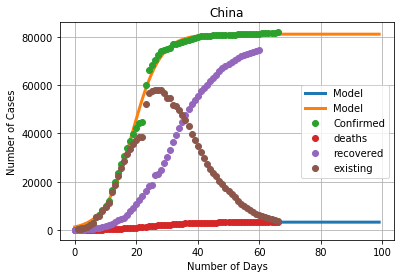

In [95]:
log_reg("China", 100)

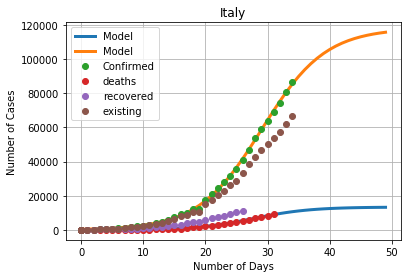

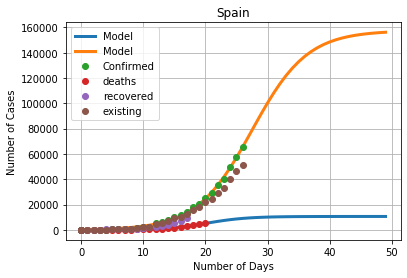

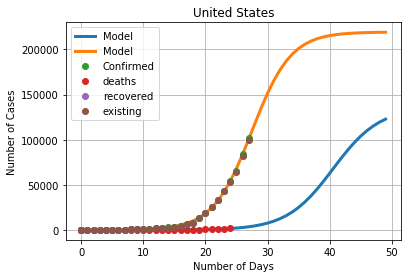

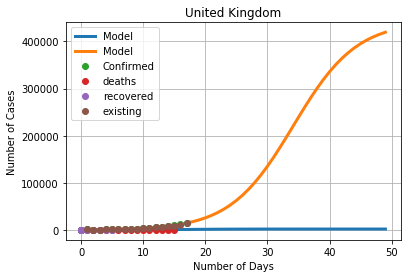

In [97]:
log_reg("Italy", 50)
log_reg("Spain", 50)
log_reg("United States", 50) 
log_reg("United Kingdom", 50) 

In [44]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#@title SEIR Model with Social Distancing { run: "auto" }

#@markdown Reproduction number
R0 = widgets.FloatSlider(min=0.9, max=5, step=0.1, value=2.4)
#@markdown Disease periods in days
t_incubation = widgets.FloatSlider(min=1, max=14, step=0.1, value=14)
t_infective  = widgets.FloatSlider(min=1, max=14, step=0.1, value=3.3)
#@markdown Population Size
N = widgets.IntSlider(min=1000, max=350000, step=1000, value=89000)
#@markdown Initial number exposed
n = widgets.IntSlider(min=0, max=100, step=1, value=45)
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = widgets.FloatSlider(min=0, max=30, step=0.1, value=2)
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = widgets.IntSlider(min=0, max=100, step=1, value=80)

def hola(R0, t_incubation, t_infective, N, n, t_social_distancing, u_social_distancing):
    # initial number of infected and recovered individuals
    e_initial = n/N
    i_initial = 0.00
    r_initial = 0.00
    s_initial = 1 - e_initial - i_initial - r_initial

    alpha = 1/t_incubation
    gamma = 1/t_infective
    beta = R0*gamma

    def step(t):
        return 1 if t >= 7*t_social_distancing else 0

    # SEIR model differential equations.
    def deriv(x, t, u, alpha, beta, gamma):
        s, e, i, r = x
        dsdt = -(1-u*step(t)/100)*beta * s * i
        dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
        didt = alpha * e - gamma * i
        drdt =  gamma * i
        return [dsdt, dedt, didt, drdt]

    t = np.linspace(0, 210, 210)
    x_initial = s_initial, e_initial, i_initial, r_initial
    s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
    s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

    # plot the data
    fig = plt.figure(figsize=(12, 10))
    ax = [fig.add_subplot(311, axisbelow=True), 
          fig.add_subplot(312)]

    pal = sns.color_palette()

    ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
    ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
    ax[0].set_xlabel('Weeks following Initial Campus Exposure')
    ax[0].set_xlim(0, t[-1]/7)
    ax[0].set_ylim(0, N)
    ax[0].legend([
        'Susceptible', 
        'Exposed/no symptoms', 
        'Infectious/symptomatic',
        'Recovered'], 
        loc='best')
    ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
    ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
    ax[0].annotate("Start of social distancing",
        (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
        arrowprops=dict(arrowstyle='->'))
    ax[0].annotate("Herd Immunity without social distancing",
        (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
        arrowprops=dict(arrowstyle='->'))

    ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
    ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
    ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
    ax[1].set_xlim(0, t[-1]/7)
    ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
    ax[1].set_xlabel('Weeks following Initial Campus Exposure')
    ax[1].legend([
        'Infective/Symptomatic', 
        'Exposed/Not Sympotomatic'],
        loc='upper right')
    ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

    y0 = N*(e0 + i0)
    k0 = np.argmax(y0)
    ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

    y = N*(e + i)
    k = np.argmax(y)
    ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

    for a in ax:
        a.xaxis.set_major_locator(plt.MultipleLocator(5))
        a.xaxis.set_minor_locator(plt.MultipleLocator(1))
        a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        a.grid(True)

    plt.tight_layout()
    
interact(hola,R0=R0, t_incubation=t_incubation, t_infective=t_infective, N=N, n=n, t_social_distancing=t_social_distancing, 
         u_social_distancing=u_social_distancing);

interactive(children=(FloatSlider(value=2.4, description='R0', max=5.0, min=0.9), FloatSlider(value=14.0, desc…

## Información por regiones

In [51]:
df_sp_it_fr_conf.head()

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
0,2020-02-27,1.0,Andalucía,Spain,8414240.0,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-28,1.0,Andalucía,Spain,8414240.0,6.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-29,1.0,Andalucía,Spain,8414240.0,8.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-01,1.0,Andalucía,Spain,8414240.0,12.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-02,1.0,Andalucía,Spain,8414240.0,12.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
pd.pivot_table(df_sp_it_fr_conf, index = ['date','country', 'region'])

cases_per_100000  \
date       country region                                      
0          France  Auvergne.Rhône.Alpes                 0.00   
                   Bourgogne.Franche.Comté              0.00   
                   Bretagne                             0.00   
                   Centre.Val.de.Loire                  0.00   
                   Corse                                0.00   
...                                                      ...   
2020-03-25 Spain   Madrid                             219.06   
                   Melilla                             43.94   
                   Murcia                              31.93   
                   Navarra                            182.97   
                   País Vasco                         148.16   

                                            cases_registered  deceassed  \
date       country region                                                 
0          France  Auvergne.Rhône.Alpes                  0.0        0.0   
                   Bourgogne.Franche.Comté               0.0        0.0   
                   Bretagne                              0.0        0.0   
                   Centre.Val.de.Loire                   0.0        0.0   
                   Corse                                 0.0        0.0   
...                                                      ...        ...   
2020-03-25 Spain   Madrid                            14597.0     1825.0   
                   Melilla                              38.0        0.0   
                   Murcia                              477.0        5.0   
                   Navarra                            1197.0       33.0   
                   País Vasco                         3271.0      155.0   

                                            deceassed_per_100000  \
date       country region                                          
0          France  Auvergne.Rhône.Alpes                     0.00   
                   Bourgogne.Franche.Comté                  0.00   
                   Bretagne                                 0.00   
                   Centre.Val.de.Loire                      0.00   
                   Corse                                    0.00   
...                                                          ...   
2020-03-25 Spain   Madrid                                  27.39   
                   Melilla                                  0.00   
                   Murcia                                   0.33   
                   Navarra                                  5.04   
                   País Vasco                               7.02   

                                            intensive_care  \
date       country region                                    
0          France  Auvergne.Rhône.Alpes                0.0   
                   Bourgogne.Franche.Comté             0.0   
                   Bretagne                            0.0   
                   Centre.Val.de.Loire                 0.0   
                   Corse                               0.0   
...                                                    ...   
2020-03-25 Spain   Madrid                           1150.0   
                   Melilla                             2.0   
                   Murcia                             33.0   
                   Navarra                            51.0   
                   País Vasco                        119.0   

                                            intensive_care_per_1000000  \
date       country region                                                
0          France  Auvergne.Rhône.Alpes                           0.00   
                   Bourgogne.Franche.Comté                        0.00   
                   Bretagne                                       0.00   
                   Centre.Val.de.Loire                            0.00   
                   Corse                                          0.00   
...                      

In [53]:
df_sp_it_fr_conf = df_sp_it_fr_conf.fillna(0)


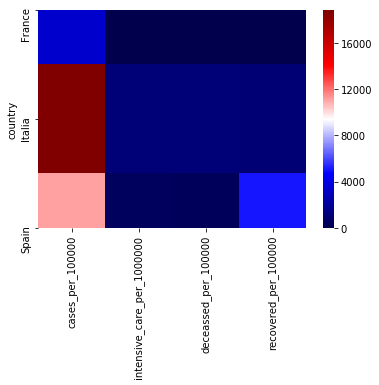

In [57]:
_ = sns.heatmap(pd.pivot_table(df_sp_it_fr_conf, index = 'country', aggfunc = "sum")[['cases_per_100000',
       'intensive_care_per_1000000', 'deceassed_per_100000','recovered_per_100000']], cmap= "seismic")

In [58]:
df_italia = df_sp_it_fr_conf[df_sp_it_fr_conf['country'] == "Italia"]
df_spain = df_sp_it_fr_conf[df_sp_it_fr_conf['country'] == "Spain"]
df_italia.head()

,date,region_code,region,country,population,cases_registered,cases_per_100000,intensive_care,intensive_care_per_1000000,deceassed,deceassed_per_100000,recovered,recovered_per_100000
532,2020-02-24,13.0,Abruzzo,Italia,1311580.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00
533,2020-03-20,13.0,Abruzzo,Italia,1311580.0,449.0,34.23,48.0,3.66,17.0,1.30,10.0,0.76
534,2020-02-26,13.0,Abruzzo,Italia,1311580.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00
535,2020-03-22,13.0,Abruzzo,Italia,1311580.0,587.0,44.76,49.0,3.74,33.0,2.52,15.0,1.14
536,2020-03-24,13.0,Abruzzo,Italia,1311580.0,689.0,52.53,57.0,4.35,46.0,3.51,21.0,1.60


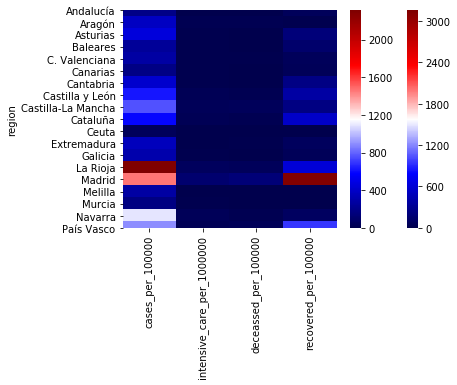

In [62]:
_ = sns.heatmap(pd.pivot_table(df_italia, index = 'region', aggfunc = "sum")[['cases_per_100000',
       'intensive_care_per_1000000', 'deceassed_per_100000','recovered_per_100000']], cmap= "seismic")

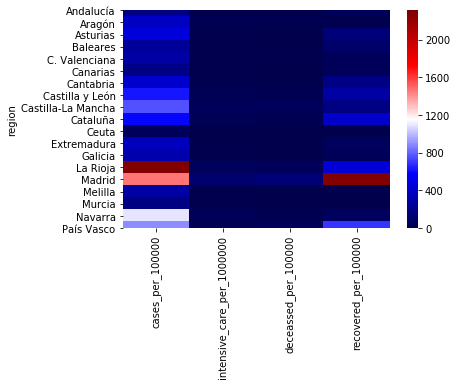

In [63]:
_ = sns.heatmap(pd.pivot_table(df_spain, index = 'region', aggfunc = "sum")[['cases_per_100000',
       'intensive_care_per_1000000', 'deceassed_per_100000','recovered_per_100000']], cmap= "seismic")

In [60]:
features = ['population','cases_registered', 'cases_per_100000', 'intensive_care',
       'intensive_care_per_1000000', 'deceassed', 'deceassed_per_100000',
       'recovered', 'recovered_per_100000']
t_test_features(df_italia,df_spain, 0.95, features)

{'population': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.0062172160280181705 es menor a nuestra α 0.05',
 'cases_registered': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.0016204337800607405 es menor a nuestra α 0.05',
 'cases_per_100000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.00465508663707706 es menor a nuestra α 0.05',
 'intensive_care': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.00036444704194237086 es menor a nuestra α 0.05',
 'intensive_care_per_1000000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 3.3552669947650595e-08 es menor a nuestra α 0.05',
 'deceassed': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.002125237281649664 es menor a nuestra α 0.05',
 'deceassed_per_100000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 2.1037274283980933e-05 es menor a nuestra α 0.05',
 'recovered': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.023801196228891704 es menor a nuestra α 0.05',
 'recovered_per_100000': 

In [61]:
umann_whitney_features(df_italia,df_spain, 0.95, features)

{'population': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.010662344993209843 es menor a nuestra α 0.05',
 'cases_registered': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.00017344063400224867 es menor a nuestra α 0.05',
 'cases_per_100000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 0.0034361774319503434 es menor a nuestra α 0.05',
 'intensive_care': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 9.18519127044035e-15 es menor a nuestra α 0.05',
 'intensive_care_per_1000000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 4.973376982565722e-13 es menor a nuestra α 0.05',
 'deceassed': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 1.053271921824115e-06 es menor a nuestra α 0.05',
 'deceassed_per_100000': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 2.8481861502101917e-06 es menor a nuestra α 0.05',
 'recovered': 'Se rechaza la hipótesis nula (H0). Nuestro p-valor 9.688559592242476e-15 es menor a nuestra α 0.05',
 'recovered_per_100000':